In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import scipy
import joblib
import copy
from sklearn.decomposition import PCA

In [3]:
def generate_kmer_database(path_to_fasta_db,path_outfile):
    outfile = open(path_outfile,"w+")
    with open(path_to_fasta_db,"r") as f:
        for line in f:
            if line[0] != ">":
                window = 9
                for i in range(len(line)-window):
                    print(line[i:i+window],file=outfile)
    outfile.close()



def read_results_files(path_to_results,peptide_lengths_of_interest,MHCs_of_interest=None):
    """Reading the results derived from the netMHCIIpan output and returns a directory of 
        the epitopes with the general structure: data[protein][allele] = [epitope,epitope]
    Args:
        path_to_results (str): Path to the netMCHIIpan results

    Returns:
        dict,dict: The results saved in a SB and WB dict
    """
    # The dataframes
    SB_score = dict()
    for file in os.listdir(path_to_results):
        protein = file.split(".")[1]
        length = file.split(".")[2]
        if length not in peptide_lengths_of_interest:
            continue

        SB_score[protein] = dict()

        infile = open(path_to_results + "/" + file, "r")
        for line in infile:
            line = line.split()
            if len(line) > 1:
                if line[1] == "Allele:":
                    allele = line[-1]
                elif line[-1] == "<=SB":
                    if MHCs_of_interest is not None:
                        if allele in MHCs_of_interest:
                            if allele not in SB_score[protein].keys():
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele] = [[int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]]]
                            else:
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele].append([int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]])
                    else:
                        if allele not in SB_score[protein].keys():
                                # [pos,peptide,of,core,identity, binding_score]
                                SB_score[protein][allele] = [[int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]]]
                        else:
                            # [pos,peptide,of,core,identity, binding_score]
                            SB_score[protein][allele].append([int(line[0]), line[2], int(line[3]), line[4], line[6], line[8]])

    return SB_score


def get_HLA_freqs(path_to_HLA_frequencies):
    """Getting the frequencies of the HLA molecules in the In vitro dataset

    Args:
        path_to_HLA_frequencies (str): path to the frequencies

    Returns:
        dict: HLA with it's frequency
    """
    HLA_freqs = dict()
    infile = open(path_to_HLA_frequencies, "r")
    for line in infile:
        line = line.split()
        allele = line[0]
        freq = float(line[1])
        HLA_freqs[allele] = freq
    return HLA_freqs


def encode_peptide_aaindex(aa_seq,aaindex_PCA):
    """Enocding an aa-seqquence using the AAindex encoding scheme.

    Args:
        aa_seq (str): The aa-sequence we want to encode
        aaindex_PCA (pd.DataFrame):  A pandas dataframe which holds the AAindex encoding scheme

    Returns:
        np.array: The encoded peptide sequence
    """

    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print("Encoding error")
                sys.exit(1)
    return np.array(encoded_aa_seq)


def add_binding_core_annotataions(peptide,core):
    core_start = peptide.find(core)
    core_indexes = list(range(core_start,core_start + len(core)))
    indexes = np.array([0 if i not in core_indexes else 1 for i in range(len(peptide))])
    indexes = indexes.reshape(-1,1)
    return np.array(indexes)


def predict_immunogenecity(peptide,core,path_to_models):
    aaindex_PCA = pd.read_csv('/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/PCA_repr_aa.csv',index_col=0)
    aaindex_PCA = (aaindex_PCA - aaindex_PCA.mean()) / aaindex_PCA.std()
    aaindex_encoding = encode_peptide_aaindex(peptide,aaindex_PCA)
    core_encoding = add_binding_core_annotataions(peptide,core)
    total_encoding = np.concatenate((core_encoding,aaindex_encoding),axis=1)
    total_encoding = total_encoding.reshape(1,-1)

    all_predictions = []
    for model in os.listdir(path_to_models):
        path_to_model = os.path.join(path_to_models,model)
        regressor = joblib.load(path_to_model)
        prediction = regressor.predict(total_encoding)
        all_predictions.append(prediction)

    average_prediction = np.mean(all_predictions)
    return average_prediction


def read_immunogenecity(path_to_immunogenecity):
    immunogenecity = dict()
    with open(path_to_immunogenecity,"r") as infile:
        for line in infile:
            protein,score = line.split()
            immunogenecity[protein] = float(score)
    return immunogenecity

def get_9_mer_lib(path_to_ninemers):
    """Creates the 9mer libaries used to create the toll profiles. Takes in the results from fasta2pep and creates dictionary with the libary

    Args:
        path_to_ninemers (str): path to results from fasta2pep

    Returns:
        dict: key is 9mer and value is the count of occurences
    """
    infile = open(path_to_ninemers,"r")
    lib = dict()
    total_lines = infile.readlines()
    for line in tqdm(total_lines,total=len(total_lines)):
        line = line.split()
        nine_mer = line[0]
        if nine_mer not in lib.keys():
            lib[nine_mer] = 1
        else:
            lib[nine_mer] += 1
    return lib

# generate_kmer_database("/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/extracted_variable_sequences_sorted_redundancy_reduced_clean_format.fasta","/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/9_mers_IMGT_new_database.txt")
path_to_models = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/models"
path_to_IMGT_9_mers = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/9_mers_IMGT_new_database.txt" # PATH TO IMGT 9-mer database
IMGT_9mers = get_9_mer_lib(path_to_IMGT_9_mers)

100%|██████████| 4030400/4030400 [00:01<00:00, 2652671.61it/s]


In [4]:
path_to_results = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/Humab_theraputics_data/newMHCIIpan_results"
lengths_of_interest = ["15"]
MHCs_of_interest = ['DRB1_0101', 'DRB3_0202', 'DRB1_0701', 'DRB1_0401', 'DRB1_1101', 'DRB4_0101', 'DRB5_0101', 'DRB1_1501', 'DRB1_0407', 'DRB1_0301', 'DRB1_0403', 'DRB1_1301', 'DQA10301-DQB10302', 'DRB1_0901', 'DRB1_1406', 'DQA10102-DQB10602', 'DRB1_1402', 'DRB1_0802', 'DQA10501-DQB10201', 'DQA10101-DQB10501']
SB_results = read_results_files(path_to_results,lengths_of_interest,MHCs_of_interest=None)
path_freqs = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/code_github/data/DRB_world_average copy.txt"
path_freqs = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/code_github/data/IX_HLA_frequencies.txt"
HLA_freqs = get_HLA_freqs(path_freqs)
path_to_immunogenecity = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/MHCII/Humab_theraputics_data/Humab_immunogenecity.txt"
imm_scores = read_immunogenecity(path_to_immunogenecity)


## Analyze immunogenecity distrobutions

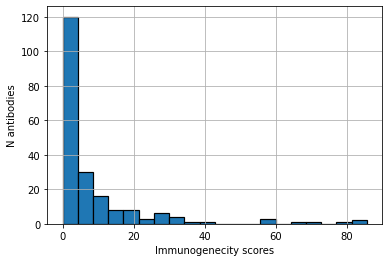

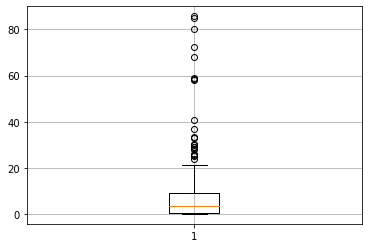

In [32]:
imm = np.array([float(x) for x in imm_scores.values()])
plt.hist(imm,bins=20,edgecolor='black', linewidth=1.2)
plt.xlabel("Immunogenecity scores")
plt.ylabel("N antibodies")
plt.grid(True)
plt.show()
plt.boxplot(imm)
plt.grid(True)
plt.show()

In [23]:
def predict_scores_threeway(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if peptide[3] not in IMGT_9mers.keys():
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
                else:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] -= allele_freq
                    else:
                        predicted_scores[theraputic] -= 0.2*allele_freq
    return predicted_scores

def predict_scores_two_state(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if peptide[3] not in IMGT_9mers.keys():
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
    return predicted_scores

def predict_scores_one_state(SB_results,IMGT_9mers):
    predicted_scores = dict()
    predicted_imm_scores = []
    for theraputic in tqdm(SB_results.keys(),total=len(SB_results.keys())):
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            try:
                allele_freq = HLA_freqs[allele]
            except KeyError:
                continue
            for peptide in SB_results[theraputic][allele]:
                if allele[0:4] == "DRB1":
                    predicted_scores[theraputic] += allele_freq
                else:
                    predicted_scores[theraputic] += 0.2*allele_freq
    return predicted_scores

In [24]:
three_way_scores = predict_scores_threeway(SB_results,IMGT_9mers)
two_state_scores = predict_scores_two_state(SB_results,IMGT_9mers)
one_state_scores = predict_scores_one_state(SB_results,IMGT_9mers)

100%|██████████| 205/205 [00:00<00:00, 61394.67it/s]


In [27]:
theraputics = [x for x in SB_results.keys()]
threeway_scores = [three_way_scores[x] for x in theraputics]
twostate_scores = [two_state_scores[x] for x in theraputics]
onestate_scores = [one_state_scores[x] for x in theraputics]
immunogenecity_scores = [imm_scores[x] for x in theraputics]

In [29]:
df = pd.DataFrame({"Theraputics":theraputics,"Threeway":threeway_scores,"Twostate":twostate_scores,"Onestate":onestate_scores,"immunogenecity_scores":immunogenecity_scores})
df = df[df.Theraputics != "Hemocyanin"]

## Boot-strapping

In [10]:
import random
random.seed(0)
N_samples = 10000
threeway_better_than_two_state = 0
for N in range(N_samples):
    bootstrapped_df = df.sample(n=df.shape[0], replace=True)
    threeway_pearson_coeff, p_value = scipy.stats.pearsonr(bootstrapped_df["Threeway"],bootstrapped_df["immunogenecity_scores"])
    twostate_pearson_coeff, p_value = scipy.stats.pearsonr(bootstrapped_df["Twostate"],bootstrapped_df["immunogenecity_scores"])
    if threeway_pearson_coeff > twostate_pearson_coeff:
        threeway_better_than_two_state += 1

print(threeway_better_than_two_state)

9289


In [11]:
10000 - 0.05*N_samples

9500.0

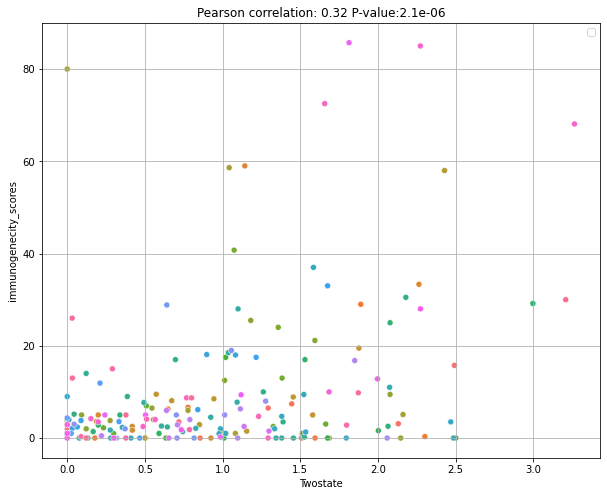

In [13]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df,x="Twostate",y="immunogenecity_scores",hue="Theraputics")
coeff, p_value = scipy.stats.spearmanr(df["Twostate"],df["immunogenecity_scores"])
# coeff, p_value = scipy.stats.pearsonr(df["Twostate"],df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,2)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

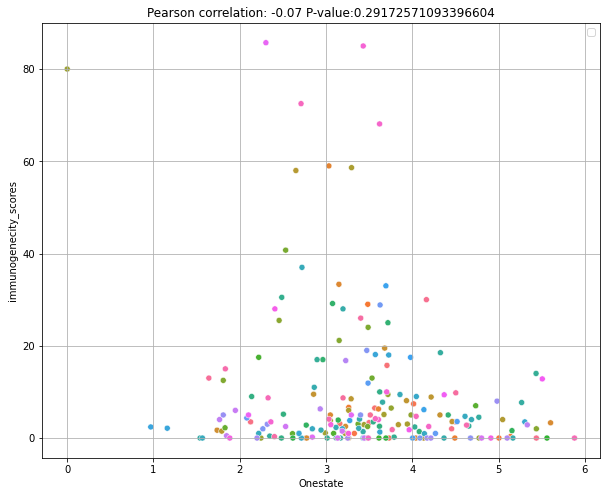

In [31]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df,x="Onestate",y="immunogenecity_scores",hue="Theraputics")
coeff, p_value = scipy.stats.spearmanr(df["Onestate"],df["immunogenecity_scores"])
# coeff, p_value = scipy.stats.pearsonr(df["Twostate"],df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,2)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(df["Threeway"].to_numpy().reshape(-1,1),df["immunogenecity_scores"].to_numpy().reshape(-1,1))

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

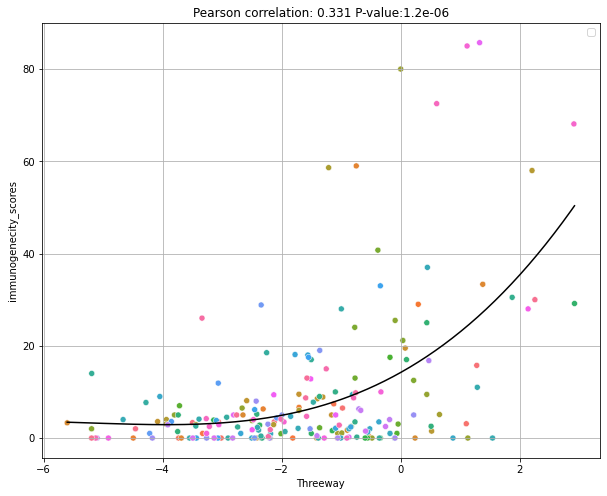

In [15]:
fig = plt.figure(figsize=(10,8))
X_seq = np.linspace(df["Threeway"].to_numpy().reshape(-1,1).min(),df["Threeway"].to_numpy().reshape(-1,1).max(),300).reshape(-1,1)
plt.plot(X_seq,polyreg.predict(X_seq),color="black")
sns.scatterplot(data=df,x="Threeway",y="immunogenecity_scores",hue="Theraputics")
coeff, p_value = scipy.stats.spearmanr(df["Threeway"],df["immunogenecity_scores"])
# coeff, p_value = scipy.stats.pearsonr(df["Threeway"],df["immunogenecity_scores"])
if "e" in str(p_value):
    pre,power = str(p_value).split("e-")
    p_value = f"{pre[:3]}e-{power}"

plt.title("Pearson correlation: " + str(round(coeff,3)) +" P-value:"+ str(p_value))
plt.grid(True)
plt.legend('')
plt.show()

In [17]:
from sklearn.metrics import r2_score
predictions = X_seq,polyreg.predict(X_seq)

coefficient_of_dermination = r2_score(df["immunogenecity_scores"].to_numpy().reshape(-1,1), polyreg.predict(df["Threeway"].to_numpy().reshape(-1,1)))
print(coefficient_of_dermination)

0.28392189032109894


In [16]:
def add_hits_in_human_aas(SB_results,IMGT_9mers):
    unique_hits = set()
    SB_results_w_hits = copy.deepcopy(SB_results)
    for theraputic in SB_results_w_hits.keys():
        for allele in SB_results_w_hits[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results_w_hits[theraputic][allele]:
                core = peptide[3]
                try:
                    hits = IMGT_9mers[core]
                    unique_hits.add(hits)
                except KeyError:
                    hits = 0
                peptide.append(hits)
                

    return SB_results_w_hits,unique_hits

SB_results_w_hits,unique_self_scores = add_hits_in_human_aas(SB_results,IMGT_9mers)

In [19]:
def predict_score_from_threeway(SB_results,lower_threshold,upper_threshold):
    predicted_scores = dict()
    for theraputic in SB_results.keys():
        predicted_scores[theraputic] = 0
        for allele in SB_results[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results[theraputic][allele]:
                self_similarity_score = peptide[-1]
                if self_similarity_score < lower_threshold:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] += allele_freq
                    else:
                        predicted_scores[theraputic] += 0.2*allele_freq
                elif self_similarity_score >= upper_threshold:
                    if allele[0:4] == "DRB1":
                        predicted_scores[theraputic] -= allele_freq
                    else:
                        predicted_scores[theraputic] -= 0.2*allele_freq
    return predicted_scores

def calculate_correlation_from_predicted_scores(predicted_scores_dict,imm_scores):
    predicted_scores = []
    actual_scores = []
    for theraputic in SB_results.keys():
        actual_scores.append(imm_scores[theraputic])
        predicted_scores.append(predicted_scores_dict[theraputic])
        
    # return scipy.stats.pearsonr(predicted_scores,actual_scores)
    return scipy.stats.spearmanr(predicted_scores,actual_scores)


In [20]:
sorted_range = sorted(unique_self_scores)
corr_matrix = [[0 for _ in range(len(sorted_range))] for _ in range(len(sorted_range))]

for i in tqdm(range(len(sorted_range)),total=len(sorted_range)):
    for j in range(len(sorted_range)):
        lower_threshold = sorted_range[i]
        upper_threshold = sorted_range[j]
        predicted_scores = predict_score_from_threeway(SB_results_w_hits,lower_threshold,upper_threshold)
        correlation, p_val = calculate_correlation_from_predicted_scores(predicted_scores,imm_scores)
        corr_matrix[i][j] = correlation
        
corr_matrix = np.matrix(corr_matrix)

100%|██████████| 252/252 [04:10<00:00,  1.01it/s]


In [21]:
max_i,max_j = list(np.where(corr_matrix == np.amax(corr_matrix)))
for i in range(len(max_i)):
    print("N hits:",sorted_range[max_i[i]],sorted_range[max_j[i]])
    print("Max-score:",corr_matrix[max_i[i],max_j[i]])

N hits: 1 1
Max-score: 0.33073628909500447


In [ ]:
predicted_scores = predict_score_from_threeway(SB_results_w_hits,1,1)
correlation, p_val = calculate_correlation_from_predicted_scores(predicted_scores,imm_scores)
print(correlation, p_val)

0.4038720053515563 1.9135956460770297e-09


In [ ]:
a = np.array([["luder","luder"],["dum","dum"]])

In [ ]:
np.where(a== "luder")

(array([0, 0]), array([0, 1]))

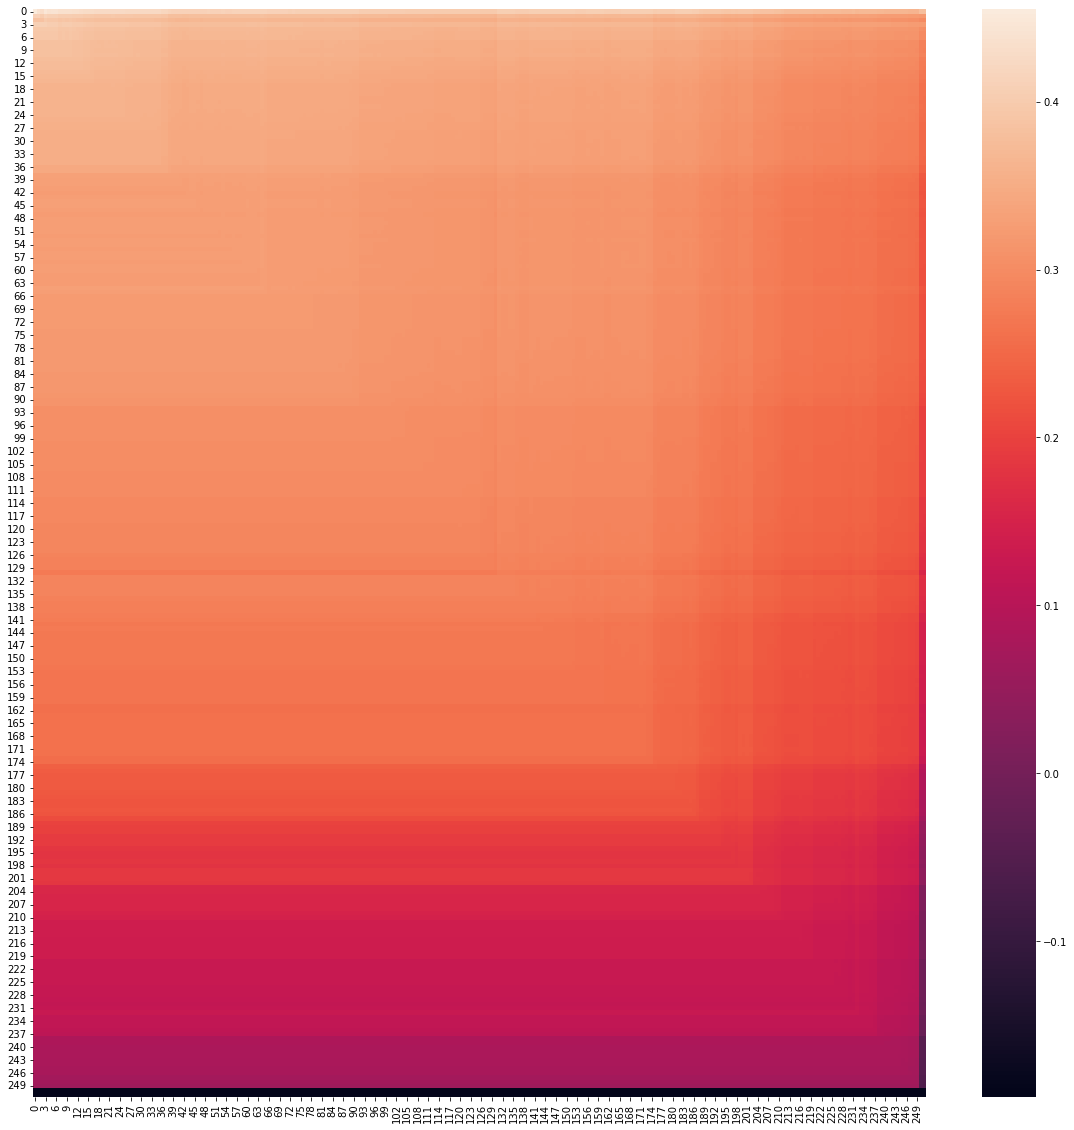

In [22]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(np.array(corr_matrix))
plt.show()

## Asses presentation profiles

Evaluate if immunogenic and non-immunogenic proteins generally have identical presentaion profiles. (Self vs. non-self)
If they generally share a structure the sign of the presentataion scores most likely influence immunogenecity

## Assess presented peptides associated with less immunogenic peptides

Bag-of-word representataion with all presented 9-mers and see how different theraputics locate. If less immunogenic peptides generally locate close to one another.. the actual presented 9-mer cores most likely influences immunogenecity

In [108]:
self_hits = dict()
for theraputic in SB_results_w_hits.keys():
    if imm_scores[theraputic] <= 20:
        self_hits[theraputic] = dict()
        for allele in SB_results_w_hits[theraputic].keys():
            allele_freq = HLA_freqs[allele]
            for peptide in SB_results_w_hits[theraputic][allele]:
                binding_core = peptide[3]
                if binding_core not in self_hits[theraputic].keys():
                    self_hits[theraputic][binding_core] = [allele_freq,peptide[-1]]
                else:
                    self_hits[theraputic][binding_core][0] += allele_freq


In [109]:
unique_presented_cores = [list(x.keys()) for x in self_hits.values()]
unique_presented_cores = sorted(set([item for sublist in unique_presented_cores for item in sublist]),key=lambda x: IMGT_9mers[x] if x in IMGT_9mers.keys() else 0,reverse=True)
bag_of_words = dict()
for theraputic in self_hits.keys():
    bag_of_words[theraputic] = [0]*len(unique_presented_cores)
    for i,core in enumerate(unique_presented_cores):
        if core in list(self_hits[theraputic].keys()):
            bag_of_words[theraputic][i] = 1

In [112]:
len(unique_presented_cores)

1255

In [113]:
labels = list(bag_of_words.keys())
X = np.array([bag_of_words[x] for x in labels])

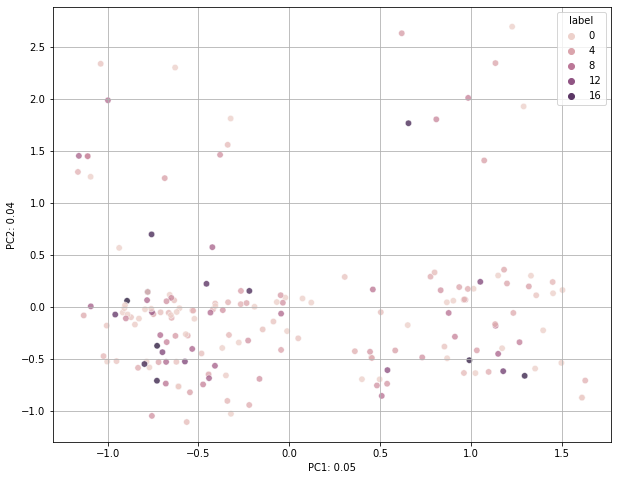

In [114]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalDf["label"] = [imm_scores[x] for x in labels]
fig,axs = plt.subplots(figsize=(10,8))
sns.scatterplot(data=principalDf,x="PC1",y="PC2",hue="label",alpha=0.8,s=40)
axs.set_xlabel(f"PC1: {pca.explained_variance_ratio_[0]:.2f}")
axs.set_ylabel(f"PC2: {pca.explained_variance_ratio_[1]:.2f}")
plt.grid(True)
plt.show()

In [118]:
from sklearn.neighbors import DistanceMetric
import sklearn

# dist = DistanceMetric.get_metric('euclidean')
# dist_mat = dist.pairwise(X)
dist_mat = sklearn.metrics.pairwise.cosine_distances(X)

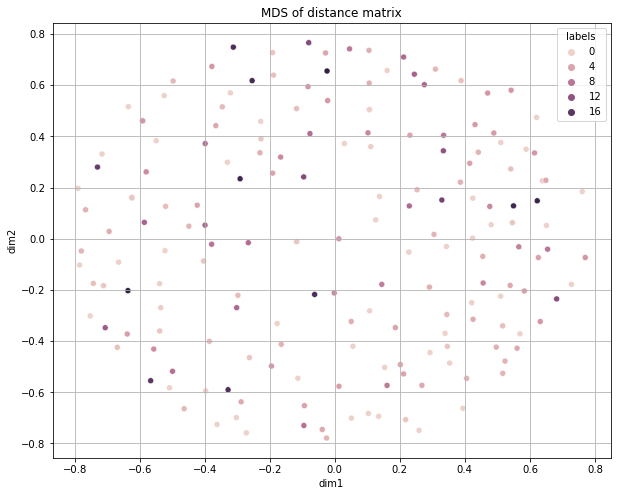

In [120]:

def MDS_analysis(X,labels):
    from sklearn.manifold import MDS
    distance_matrix = X
    mds = MDS(random_state=0,dissimilarity='precomputed',metric=True)
    MDS_transform = mds.fit_transform(distance_matrix)
    # MDS_transform = MDS_transform + np.random.normal(0,0.01,MDS_transform.shape)
    
    principalDf = pd.DataFrame(data = MDS_transform
             , columns = ['dim1', 'dim2'])
    principalDf["labels"] = [imm_scores[x] for x in labels]

    fig,axs = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=principalDf, x = principalDf.dim1, y= principalDf.dim2, hue = "labels") # ,style="labels"
    axs.set_xlabel(f"dim1")
    axs.set_ylabel(f"dim2")

    # confidence_ellipse(principalDf[principalDf["labels"] == "1"]["dim1"].to_numpy(), principalDf[principalDf["labels"] == "1"]["dim2"].to_numpy(), axs, edgecolor='blue')
    # confidence_ellipse(principalDf[principalDf["labels"] == "0"]["dim1"].to_numpy(), principalDf[principalDf["labels"] == "0"]["dim2"].to_numpy(), axs, edgecolor='orange')

    
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    labels_to_handles = {label:handel for handel,label in zip(handles, labels)}

    # if "nan" in labels_to_handles.keys():
    #     sorted_labels = sorted([x for x in labels_to_handles.keys() if x != "nan"],key=lambda x: int(x)) + ["nan"]
    #     sorted_handles = [labels_to_handles[x] for x in sorted_labels] + [labels_to_handles["nan"]]

    # else:
    #     sorted_labels = sorted(labels_to_handles.keys(),key=lambda x: int(x))
    #     sorted_handles = [labels_to_handles[x] for x in sorted_labels]

    # plt.legend(sorted_handles,sorted_labels,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.title("MDS of distance matrix")
    plt.show()

MDS_analysis(dist_mat,labels)

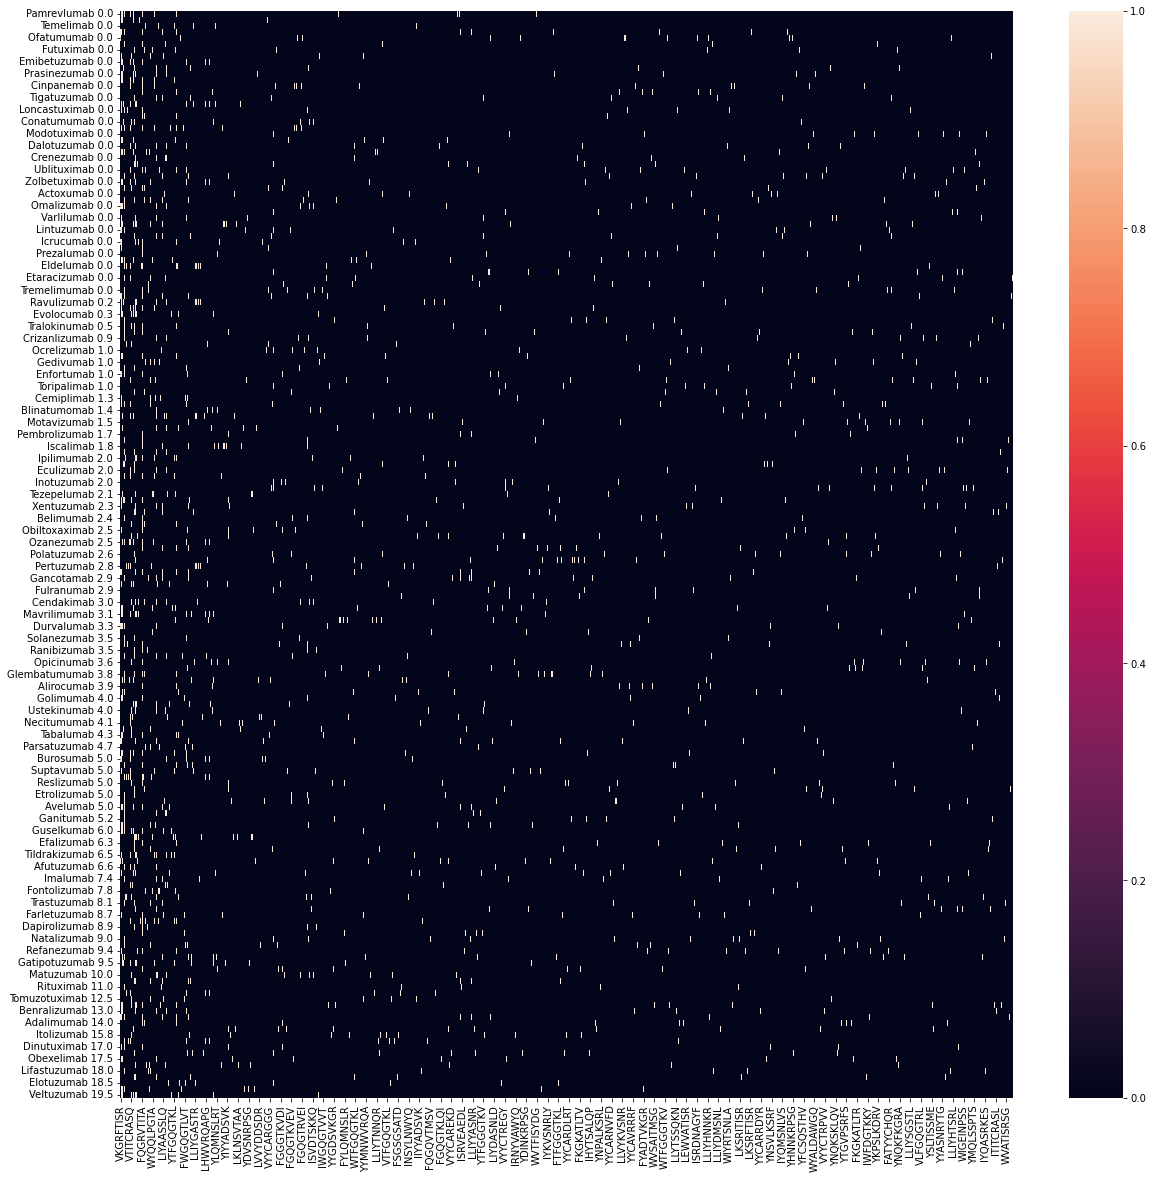

In [129]:
import seaborn
indexes = sorted([x + " " + str(round(imm_scores[x],1)) for x in labels],key=lambda x: float(x.split()[-1]))
columns = [x for x in unique_presented_cores]
df = pd.DataFrame(X,columns=unique_presented_cores,index=indexes)
plt.figure(figsize=(20,20))
sns.heatmap(df)
plt.show()

# Asses distrobutions of self-hits

Does it makes sense that peptides found >1 time would be considered less immunogenic?

In [29]:
distrobutions = dict()
for theraputic in SB_results_w_hits.keys():
    distrobutions[theraputic] = []
    for allele in SB_results_w_hits[theraputic].keys():
        allele_freq = HLA_freqs[allele]
        for peptide in SB_results_w_hits[theraputic][allele]:
            binding_core = peptide[3]
            distrobutions[theraputic].append(peptide[-1])


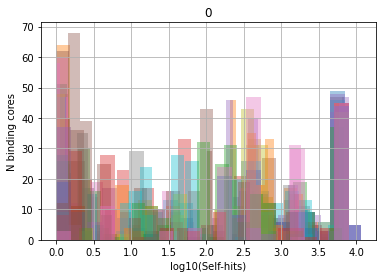

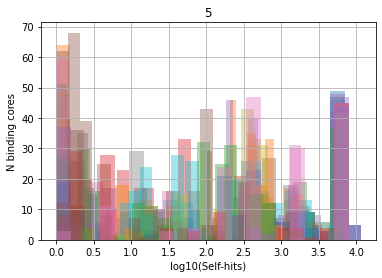

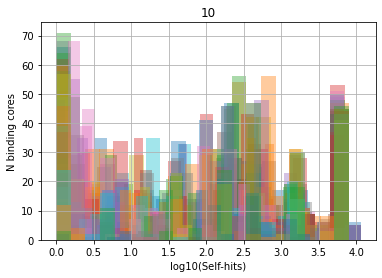

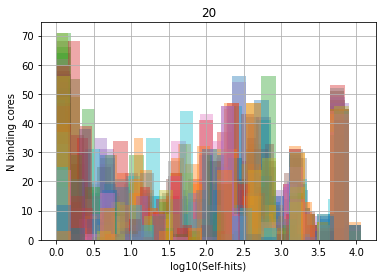

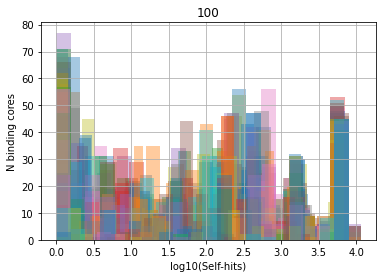

In [62]:
thresholds = [0,5,10,20,100]
for i,threshold in enumerate(thresholds):
    for theraputic in distrobutions.keys():
        if i != 0:
            if imm_scores[theraputic] <= threshold and thresholds[i-1] >= imm_scores[theraputic]:
                plt.hist(np.log10(np.array(distrobutions[theraputic]) + 1),bins=20,alpha=0.4)
        else:
            if imm_scores[theraputic] <= threshold:
                plt.hist(np.log10(np.array(distrobutions[theraputic]) + 1),bins=20,alpha=0.4)

    plt.title(threshold)
    plt.xlabel("log10(Self-hits)")
    plt.ylabel("N binding cores")
    plt.grid(True)
    plt.show()

In [60]:
np.log10(10000)

4.0